In [34]:
from zipfile import ZipFile
filename = "/content/60MCI_EMCI_CN.zip"

with ZipFile(filename,'r') as zip:
  print("Extracting of the file ...")
  zip.extractall()
  print("Done")

Extracting of the file ...
Done


In [35]:
from imutils import paths
import xlrd
import pandas as pd
df = pd.read_csv('/content/60MCI_EMCI_CN_3_03_2022.csv')
images_paths = list(paths.list_files("/content/ADNI"))
lables = []
i = 0
while i < 600:
  Id = images_paths[i].split("/")[3]
  n = 0
  while n < len(df.Subject):
    if df.Subject[n] == Id:
      lables.append(df.Group[n])
      break
    n = n +1
  i =i+1

print(len(lables),len(images_paths))


600 622


In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import skimage.transform as skTrans
dataset =[]


i = 0 
while i <600:
  image = nib.load(images_paths[i])
  image = image.get_fdata()
  result1 = skTrans.resize(image, (64,64,24), order=1, preserve_range=True)
  result1 = result1.reshape(64, 64, 24)
  dataset.append(result1)
  i = i + 1
  print(result1.shape)
  #print(c.shape)


Text(0.5, 0.98, 'Center slices for anatomical image')

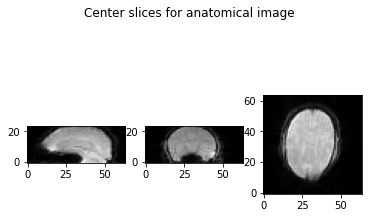

In [37]:
def show_slices(slices):
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")

show_slices([dataset[34][30, :, :],
             dataset[34][:, 30, :],
             dataset[34][:, :, 12]])
plt.suptitle("Center slices for anatomical image")  


In [ ]:
print(len(dataset),len(lables))
print(dataset[0])

In [51]:
import numpy as np
from tensorflow.keras.utils import to_categorical

EMCI_image = []
CN_image = []
MCI_image = []

EMCI_lables = []
CN_lables = []
MCI_lables = []

i = 0 
while i <len(lables):
  if lables[i] == 'EMCI':
    EMCI_lables.append(lables[i])
    EMCI_image.append(dataset[i])
  elif lables[i] == 'CN':
    CN_lables.append(lables[i])
    CN_image.append(dataset[i])
  else:
    MCI_lables.append(lables[i])
    MCI_image.append(dataset[i])
  i = i + 1

print(len(EMCI_lables),len(CN_lables),len(MCI_lables))
print(len(EMCI_image),len(CN_image),len(MCI_image))



Training_images = EMCI_image[0:150]  + CN_image[0:60] + MCI_image[0:70]
Training_labels = EMCI_lables[0:150] + CN_lables[0:60] + MCI_lables[0:70]
Testing_images = EMCI_image[151:341]  + CN_image[61:123] + MCI_image[71:136]
Testing_labels = EMCI_lables[151:341] + CN_lables[61:123] + MCI_lables[71:136]

Training_images_np = np.array(Training_images) 
Training_labels_np = np.array(Training_labels)
Testing_images_np = np.array(Testing_images) 
Testing_labels_np = np.array(Testing_labels)

print(Training_images_np.shape)
print(Training_labels_np.shape)
print(Testing_images_np.shape)
print(Testing_labels_np.shape)

341 123 136
341 123 136
(280, 64, 64, 24)
(280,)
(317, 64, 64, 24)
(317,)


In [52]:
Training_images_np = Training_images_np/255.00
Testing_images_np = Testing_images_np/255.00

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

Training_labels_np = label_encoder.fit_transform(Training_labels_np)


label_encoder = LabelEncoder()
Testing_labels_np = label_encoder.fit_transform(Testing_labels_np)


Training_labels_np = to_categorical(Training_labels_np)
Testing_labels_np = to_categorical(Testing_labels_np)

#aug_traning_images = np.expand_dims(aug_traning_images, axis=-1)
#aug_testing_images = np.expand_dims(aug_testing_images, axis=-1)


print(Training_images_np.shape)
print(Training_labels_np.shape)
print(Testing_images_np.shape)
print(Testing_labels_np.shape)

(280, 64, 64, 24)
(280, 3)
(317, 64, 64, 24)
(317, 3)


In [53]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
def Alzheimer_Data_Augmentation(input_shape=(64, 64, 24)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(128, (5, 5), padding='same', strides=(1, 1), name='conv1', activation='relu'))
    model.add(MaxPool2D((9, 9), strides=(3, 3)))
    model.add(Conv2D(64, (5, 5), padding='same', strides=(1, 1), name='conv2', activation='relu'))
    model.add(MaxPool2D((7, 7), strides=(3, 3)))
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu'))
    model.add(MaxPool2D((5, 5), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu'))
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    optimizer = Adam(3.15e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model= Alzheimer_Data_Augmentation(input_shape=(64, 64, 24))
model.summary()

hist_ = model.fit(Training_images_np, Training_labels_np, batch_size=1, epochs=100, validation_data=(Testing_images_np, Testing_labels_np))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 64, 64, 128)       76928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 19, 19, 128)      0         
 2D)                                                             
                                                                 
 conv2 (Conv2D)              (None, 19, 19, 64)        204864    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv3 (Conv2D)              (None, 5, 5, 32)          18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 32)        

# New Section

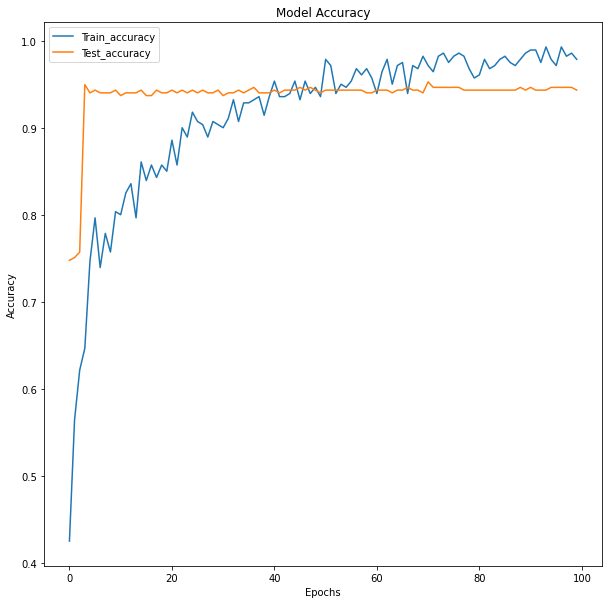

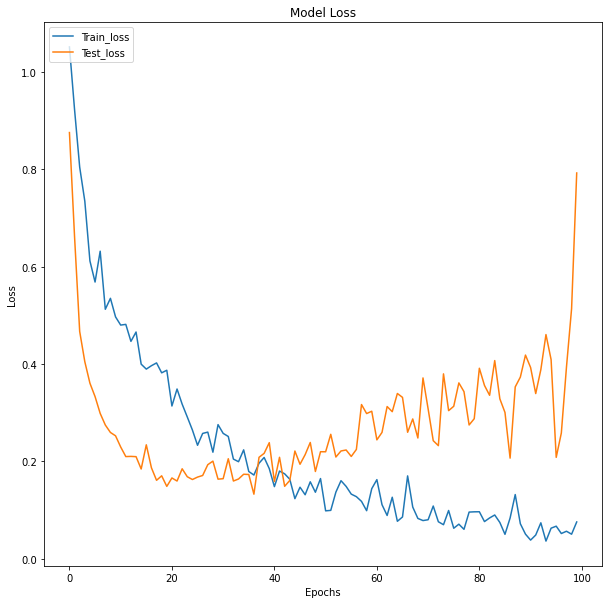

              precision    recall  f1-score   support

           0       1.00      0.76      0.86        62
           1       0.97      0.98      0.98       190
           2       0.84      1.00      0.92        65

    accuracy                           0.94       317
   macro avg       0.94      0.91      0.92       317
weighted avg       0.95      0.94      0.94       317



In [54]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10, 10))
plt.plot(hist_.history['accuracy'], label='Train_accuracy')
plt.plot(hist_.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist_.history['loss'], label='Train_loss')
plt.plot(hist_.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

from sklearn.metrics import classification_report

ypred = model.predict(Testing_images_np)
ypred = np.argmax(ypred, axis=1)
y_test_pred = np.argmax(Testing_labels_np, axis=1)
print(classification_report(y_test_pred, ypred))